# Split lines into grid

In [1]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
import os

# system paths
import sys
home = str(Path.home())
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'
from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

# aws connection*
import boto3
import awswrangler as wr

# local libraries
from src import utils

# analysis libraries
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import geopandas as gpd
import random
import itertools

import matplotlib.pyplot as plt

from shapely.geometry import box, Polygon, MultiPolygon, LineString, GeometryCollection, shape
from shapely import wkt
from shapely.ops import transform
from babelgrid import Babel

from multiprocessing.pool import Pool
from functools import partial

from loguru import logger

cm = str(datetime.today().strftime("%Y%m%d%H%m"))
cm

INFO|g|e|n|e|r|a|t|e|d| |n|e|w| |f|o|n|t|M|a|n|a|g|e|r


'202109151309'

## Sample dates

Executing 50 dates to sample from jams data set

In [ ]:
from src.runners.sample_jams import _sample_dates

In [ ]:
df = _sample_dates(start_date = '2019-01-01', end_date = '2021-08-12')

In [ ]:
print(df.date_filter[0])

## Sample lines counts

Run a query to download unique lines and number of appearance. 

- Lines 21,904,128
- Jams 507,139,112
- 50 weekdays sampled

Data is split in 6 groups to run each intersection with grids. Function `_split_groups()`. Each split contains 3,650,688 lines.

In [3]:
from src.runners.split_polygon import _get_lines

In [ ]:
df_lines = _get_lines(update_data = False)

In [ ]:
print(df_lines.shape)
print(sum(df_lines.count_lines))
df_lines.head(3)

In [ ]:
from siuba import group_by, summarize, _
(df_lines
  >> group_by(_.split)
  >> summarize(lines = _.line_wkt.count())
  )

## Coarse grid split

In [ ]:
from src.runners import split_polygon

In [ ]:
# Plotting H3 cells

# H3 cells grid
tiles = Babel('h3').polyfill(geometry, resolution=1)
# S2 cells grid
#tiles = Babel('s2').polyfill(geometry, resolution=4)
len(tiles)

if False:
    tiles_gdf = gpd.GeoDataFrame([t.to_dict() for t in tiles], geometry='shapely')
    df = tiles_gdf
    m = folium.Map(location=[40.70, -73.94], zoom_start=2, tiles='CartoDB positron')
    for _, r in df.iterrows():
        # Without simplifying the representation of each borough,
        # the map might not be displayed
        sim_geo = gpd.GeoSeries(r['shapely']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                               style_function=lambda x: {'fillColor': 'orange'})
        geo_j.add_to(m)
    m

In [ ]:
tiles[0].geometry.wkt

In [ ]:
# Run this in 6 separated instances 
logger.warning('Better to run it from terminal in different instances')
# df_coarse_split = _create_coarse_grid(df_lines, tiles, split = )

### Coarse grid union

Union of results from parallelization in 6 instances. 

- Cells: 57
- Lines: 22,214,341
- Run time per instance: 3 hrs.

In [ ]:
from src.runners.split_polygon import _coarse_union

In [ ]:
mypath = "/home/soniame/private/projects/corona_geo_id/coarse_grid/"
csv_files = [os.path.join(mypath, x) for x in os.listdir(mypath)]

In [ ]:
# Sample: union of lines
csv_files = ['/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_1.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_2.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_3.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_4.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_5.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_6.csv']
csv_files
df_coarse = _coarse_union(csv_files)

In [ ]:
# Export to csv 
coarse_path = '/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/coarse_id/coarse_grid_sample.csv'
df_coarse.to_csv(coarse_path, index = False)

### Coarse grid distribution

In [ ]:
coarse_path = '/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/coarse_id/coarse_grid_sample.csv'
df_coarse_R1 = pd.read_csv(coarse_path)
df_coarse_R1 = df_coarse_R1.rename(columns = {'line':'line_wkt'})

In [ ]:
print(df_coarse_R1.shape)
print(df_coarse_R1.coarse_wkt.nunique())
print(df_coarse_R1.line_wkt.nunique())
# df_coarse_R1.head()

In [ ]:
# Union de coarse y merge con count of jams
df_merge = df_coarse_R1.merge(df_lines, how = 'left', on = 'line_wkt')
print(df_merge.shape)
df_merge.head()

In [ ]:
from siuba import group_by, ungroup, arrange, summarize, _

# Table of distribution pero H3 Cell
tab = (df_merge
  >> group_by(_.coarse_wkt)
  >> summarize(lines = _.line_wkt.count(),
               jams  = _.count_lines.sum())
  >> ungroup()
  >> arrange(-_.lines)
  )
tab.head()

In [ ]:
# Export to csv 
tab.to_csv('/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/coarse_grid_distribution.csv', index = False)

Plots

In [ ]:
tab = pd.read_csv('/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/coarse_grid_distribution.csv')

In [ ]:
tab['geometry'] = gpd.GeoSeries.from_wkt(tab['coarse_wkt'])
tab = gpd.GeoDataFrame(tab, geometry='geometry')
fig, ax = plt.subplots(1, 1)
tab.plot(column='lines', ax=ax, 
         legend=True, cmap='OrRd')
plt.title('Coarse Grid 1 - Number of lines')
plt.savefig('/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/coarse_map_LinesR1.pdf')

In [ ]:
tab['geometry'] = gpd.GeoSeries.from_wkt(tab['coarse_wkt'])
tab = gpd.GeoDataFrame(tab, geometry='geometry')
fig, ax = plt.subplots(1, 1)
tab.plot(column='jams', ax=ax, 
         legend=True, cmap='OrRd')
plt.title('Coarse Grid 1 - Number of Jams')
plt.savefig('/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/coarse_map_JamsR1.pdf')

In [ ]:
plt.scatter(tab.jams, tab.lines)

### Coarse grid union Big Polygons (R2)

Union of results from parallelization in 6 instances. 

- Cells: 
- Lines: 22,214,341
- Run time per polygon: 2 hrs.

In [ ]:
from src.runners.split_polygon import _new_res_coarse_grid
from siuba import group_by, ungroup, arrange, summarize, _

In [ ]:
# Ran in terminal
logger.warning("Only run to update resolution 2")
# _new_res_coarse_grid()

In [ ]:
from src.runners.split_polygon import _coarse_union
mypath = "/home/soniame/private/projects/corona_geo_id/coarse_grid/"
csv_files = [os.path.join(mypath, x) for x in os.listdir(mypath)]

In [ ]:
# Sample: union of lines for resolution 2
csv_files = [
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_R2_1.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_R2_2.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_R2_3.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_R2_4.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_R2_5.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_R2_6.csv']
csv_files
df_coarse_R2 = _coarse_union(csv_files)
df_coarse_R2 = df_coarse_R2.rename(columns={'coarse_wkt':'coarse_wkt_2', 'line':'line_wkt'})

In [ ]:
print(len(df_coarse_R2))
print(len(df_coarse_R1))
print(len(df_lines))

In [ ]:
df_coarse_R2.head()

In [ ]:
tab = pd.read_csv('/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/coarse_grid_distribution.csv')
bp = tab.sort_values('lines', ascending=False)[:6][['coarse_wkt']]
bp['bp'] = [1, 2, 3, 4, 5, 6]

In [ ]:
# Union of previous coarse_wkt, big polygons and line jams
# Merge of coarse wkt R1 and R2
df_coarse_R = df_lines.\
     merge(df_coarse_R1, how = 'left', on = 'line_wkt'). \
     merge(df_coarse_R2, how = 'left', on = 'line_wkt'). \
     merge(bp, how = 'left', on = 'coarse_wkt'). \
     drop_duplicates()
 
print(len(df_coarse_R))
#df_coarse_R.head()

In [ ]:
# Replace nulls for values
df_coarse_R['coarse_wkt_R'] = np.where(df_coarse_R['bp'].isna(), 
                                       df_coarse_R['coarse_wkt'], 
                                       df_coarse_R['coarse_wkt_2'])
print(sum(df_coarse_R['coarse_wkt_R'].isna()))

df_coarse_R['coarse_wkt_R'] = np.where(df_coarse_R['coarse_wkt_R'].isna(), 
                                       '(MISSING)', 
                                       df_coarse_R['coarse_wkt_R'])
print(sum(df_coarse_R['coarse_wkt_R'].isna()))

In [ ]:
# Table of distribution pero wkt union
#df_dist = (df_coarse_R
#  >> group_by(_.coarse_wkt_R)
#  >> summarize(lines = _.line_wkt.count(),
#               jams  = _.count_lines.sum(), 
#               bp = _.bp.max())
#  >> ungroup()
#  >> arrange(-_.lines)
#  )
#min_wkt = str(df_dist.sort_values('lines', ascending=True)[:1].coarse_wkt_R)

In [ ]:
# Export to csv 
coarse_R_path = '/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/coarse_id/coarse_grid_sample_R2.csv'
df_coarse_R[['line_wkt', 'count_lines', 'bp', 'coarse_wkt_R']].to_csv(coarse_R_path, index = False)

### Coarse grid distribution Big Polygons

In [ ]:
from siuba import group_by, ungroup, arrange, summarize, _

In [ ]:
df_coarse_R = pd.read_csv(coarse_R_path)

In [ ]:
print(df_coarse_R.shape)
print(df_coarse_R.coarse_wkt_R.nunique())
print(df_coarse_R.line_wkt.nunique())
df_coarse_R.head()

In [ ]:
# Table of distribution pero wkt union
tab = (df_coarse_R
  >> group_by(_.coarse_wkt_R)
  >> summarize(lines = _.line_wkt.count(),
               jams  = _.count_lines.sum(), 
               bp = _.bp.max())
  >> ungroup()
  >> arrange(-_.lines)
  )

In [ ]:
# Export to csv 
tab.to_csv('/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/coarse_grid_distribution_R.csv', index = False)

Plots

In [ ]:
tab = pd.read_csv('/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/coarse_grid_distribution_R.csv')

In [ ]:
tab = tab[tab.coarse_wkt_R != '(MISSING)']
tab['geometry'] = gpd.GeoSeries.from_wkt(tab['coarse_wkt_R'])
tab = gpd.GeoDataFrame(tab, geometry='geometry')
fig, ax = plt.subplots(1, 1)
tab.plot(column='lines', ax=ax, 
         legend=True, cmap='OrRd')
plt.title('Coarse Grid 1 - Number of lines')
plt.savefig('/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/coarse_map_LinesR2.pdf')

In [ ]:
fig, ax = plt.subplots(1, 1)
tab.plot(column='jams', ax=ax, 
         legend=True, cmap='OrRd')
plt.title('Coarse Grid 1 - Number of Jams')
plt.savefig('/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/coarse_map_JamsR2.pdf')

## Creating squares

In [8]:
from src.runners import split_polygon

In [ ]:
from shapely.geometry import box, Polygon, MultiPolygon, GeometryCollection
from shapely.wkt import loads

In [ ]:
# - Example 
# polygon = 'POLYGON((2.0117187499999822 44.38657313925715,-19.433593750000018 19.207272119703983,19.414062499999982 6.904449621538131,64.94140624999999 -3.096801256840523,81.46484374999999 37.21269961002643,45.78124999999998 24.106495997107682,53.69140624999998 51.22054369437158,3.7695312499999822 37.07257833232809,2.0117187499999822 44.38657313925715))'
# - Latin America 
# polygon = 'POLYGON ((-127.265625 34.30714385628804, -128.671875 -56.94497418085159, -28.4765625 -57.70414723434192, -29.8828125 16.97274101999902, -84.72656249999999 25.48295117535531, -116.71874999999999 35.746512259918504, -127.265625 34.30714385628804))'
# - Triángulo 
# polygon = Polygon([(0, 0), (5, 5), (5, 0)])
# - Peru
# polygon = 'POLYGON ((-77.10205078124999 -13.004557745339769, -72.158203125 -13.004557745339769, -72.158203125 -8.90678000752024, -77.10205078124999 -8.90678000752024, -77.10205078124999 -13.004557745339769))'
# - Latin america BID
polygon = 'POLYGON((-129.454 37.238,-90.781 27.311,-67.117 20.333,-68.721 17.506,-23.765 -9.114,-65.601 -60.714,-126.421 -23.479,-129.454 37.238))'
geometry = wkt.loads(polygon)
print(geometry.area)
#geometry

In [ ]:
#df_lines = split_polygon._get_lines()

In [24]:
df_coarse = split_polygon._get_coarse_grid()

2021-09-13 13:51:52.735 | INFO     | src.runners.split_polygon:_get_coarse_grid:189 - Get coarse grid
2021-09-13 13:51:52.736 | DEBUG    | src.runners.split_polygon:_get_coarse_grid:191 - From /home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/coarse_id/coarse_grid_sample_R2.csv
2021-09-13 13:55:42.010 | DEBUG    | src.runners.split_polygon:_get_coarse_grid:195 - L: 21904128


In [25]:
df_dist = split_polygon._get_dist_table()

2021-09-13 13:55:42.056 | INFO     | src.runners.split_polygon:_get_dist_table:201 - Get distribution table
2021-09-13 13:55:42.142 | DEBUG    | src.runners.split_polygon:_get_dist_table:205 - G: 91


In [28]:
print(len(df_coarse))
print(len(df_dist))

21904128
91


In [ ]:
#_threshold_density_func(geometry, .01, df_dist, df_coarse)

In [29]:
print(df_dist.shape)
print(df_coarse.shape)

(91, 4)
(21904128, 4)


In [ ]:
df_coarse[df_coarse.coarse_wkt_R == '(MISSING)'].to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/missing_ids.csv")

In [ ]:
df_coarse[df_coarse.coarse_wkt_R == '(MISSING)'].head()

## Lines intersection per square



In [ ]:
pd.DataFrame

In [6]:
cm_read = '2021083013081630344071'
mypath = f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_id/{cm_read}"
geo_id_path = max([os.path.join(mypath, x) for x in os.listdir(mypath)])
print(geo_id_path)
df_geo_id = pd.read_csv(geo_id_path)
print(len(df_geo_id.geometry.unique()))
df_geo_id.head()

/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_id/2021083013081630344071/geo_grid_area_2021083013081630344071.csv
364


,Unnamed: 0,geometry
0,0,POLYGON ((-101.8926651563943 -38.4956482719772...
1,1,"POLYGON ((-76.6095 -31.17131201701743, -76.609..."
2,2,POLYGON ((-89.25108257819717 -31.1713120170174...
3,3,"POLYGON ((-76.6095 -19.76976001418119, -76.609..."
4,4,POLYGON ((-82.93029128909859 -19.7697600141811...


In [8]:
geopath = "/home/soniame/private/projects/corona_geo_id/geo_id/"
geo_id_path = [os.path.join(geopath, x) for x in os.listdir(geopath)][1:]
geo_id_path
df_geo_lines = pd.DataFrame()
for pth in geo_id_path:
    print(pth)
    df_geo_lines = df_geo_lines.append(pd.read_csv(pth))
df_geo_lines = df_geo_lines \
    .rename(columns = {'wkt_def':'line_wkt', 'geom_def':'geo_id'})    

['/home/soniame/private/projects/corona_geo_id/geo_id/results_0.csv',
 '/home/soniame/private/projects/corona_geo_id/geo_id/results_1.csv',
 '/home/soniame/private/projects/corona_geo_id/geo_id/results_10.csv',
 '/home/soniame/private/projects/corona_geo_id/geo_id/results_100.csv',
 '/home/soniame/private/projects/corona_geo_id/geo_id/results_101.csv',
 '/home/soniame/private/projects/corona_geo_id/geo_id/results_102.csv',
 '/home/soniame/private/projects/corona_geo_id/geo_id/results_103.csv',
 '/home/soniame/private/projects/corona_geo_id/geo_id/results_104.csv',
 '/home/soniame/private/projects/corona_geo_id/geo_id/results_105.csv',
 '/home/soniame/private/projects/corona_geo_id/geo_id/results_106.csv',
 '/home/soniame/private/projects/corona_geo_id/geo_id/results_107.csv',
 '/home/soniame/private/projects/corona_geo_id/geo_id/results_108.csv',
 '/home/soniame/private/projects/corona_geo_id/geo_id/results_109.csv',
 '/home/soniame/private/projects/corona_geo_id/geo_id/results_11.csv'

In [9]:
print(df_geo_lines.shape)
print(df_geo_lines.geo_id.nunique())
print(df_geo_lines.line_wkt.nunique())

NameError: name 'df_geo_lines' is not defined

In [ ]:
df = df_geo_lines.merge(df_coarse[['line_wkt', 'count_lines']].rename(columns = {'count_lines':'jams'}))
df.head()

In [ ]:
df_coarse.line_wkt.nunique()

### Distribution of lines/jams per square

In [5]:
from siuba import group_by, ungroup, arrange, summarize, _
import geopandas as gpd
#import folium

In [ ]:
tab = (df
  >> group_by(_.geo_id)
  >> summarize(lines = _.line_wkt.count(), 
               jams = _.jams.sum())
  >> ungroup()
  >> arrange("jams")
  )
tab['geometry'] = gpd.GeoSeries.from_wkt(tab['geo_id'])
tab = gpd.GeoDataFrame(tab, geometry='geometry')

print(tab.shape)
tab.head()

In [18]:
#tab.to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/geo_lines_distribution.csv", index=False)


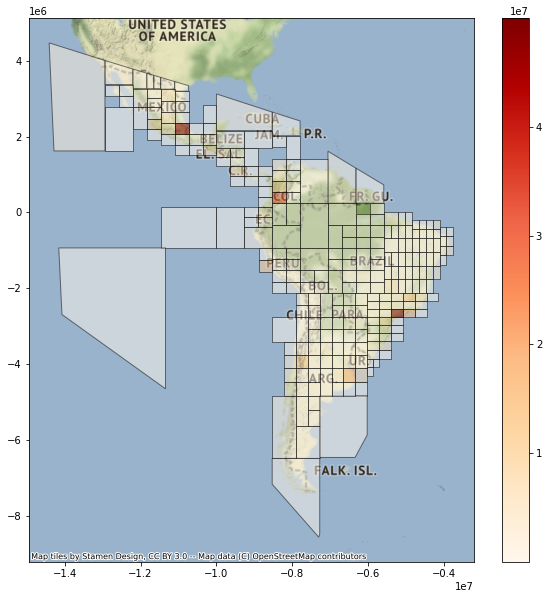

In [20]:
import matplotlib.pyplot as plt
import contextily as ctx

tab.crs = "EPSG:4326"
df_wm = tab.to_crs(epsg=3857)
ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', 
                column='jams',legend=True, cmap='OrRd')
ctx.add_basemap(ax)

In [ ]:
# FOLIUM CODE
#df = tab
#m = folium.Map(location=[-24.1792320824178, -60.97559398552432], zoom_start=2, tiles='CartoDB positron')
#for _, r in df.iterrows():
#    # Without simplifying the representation of each borough,
#    # the map might not be displayed
#    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
#    geo_j = sim_geo.to_json()
#    geo_j = folium.GeoJson(data=geo_j,
#                           style_function=lambda x: {'fillColor': 'orange'})
#    folium.Popup(r['lines']).add_to(geo_j)
#    geo_j.add_to(m)
#m

## Ratio big squares

In [110]:
tab = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/geo_lines_distribution.csv")
tab['geometry'] = gpd.GeoSeries.from_wkt(tab['geo_id'])
tab = gpd.GeoDataFrame(tab, geometry='geometry')
tab.head()

,geo_id,lines,jams,geometry
0,"POLYGON ((-73.30671875 2.170599169624747, -70....",5,9,"POLYGON ((-73.30672 2.17060, -70.00394 2.17060..."
1,"POLYGON ((-83.2150625 -8.368208011344954, -89....",7,15,"POLYGON ((-83.21506 -8.36821, -89.82063 -8.368..."
2,POLYGON ((-62.54741185860617 -18.7909338869168...,20,35,"POLYGON ((-62.54741 -18.79093, -59.73499 -18.7..."
3,"POLYGON ((-73.30671875 -8.310167358646043, -70...",3,101,"POLYGON ((-73.30672 -8.31017, -70.00394 -8.310..."
4,"POLYGON ((-56.7928125 -8.310167358646043, -60....",8,106,"POLYGON ((-56.79281 -8.31017, -60.09559 -8.310..."


In [113]:
ratio = tab \
    .sort_values('jams', ascending=False) \
    .assign(ratio = lambda x: x.jams / (sum(df_dist.jams)*.01))
ratio[ratio.ratio > 2]

,geo_id,lines,jams,geometry,ratio
258,POLYGON ((-48.48532371721236 -23.9941350636253...,1963031,49997157,"POLYGON ((-48.48532 -23.99414, -48.48532 -22.2...",9.858667
257,POLYGON ((-99.72896875000001 20.74968832471787...,1595312,47071310,"POLYGON ((-99.72897 20.74969, -96.42619 20.749...",9.281735
256,"POLYGON ((-73.30671875 2.170599169624747, -76....",863945,29708924,"POLYGON ((-73.30672 2.17060, -76.60950 2.17060...",5.858141
255,POLYGON ((-59.73499423032741 -37.1322753113907...,790006,20140620,"POLYGON ((-59.73499 -37.13228, -59.73499 -34.5...",3.971419
254,POLYGON ((-42.86048846065484 -22.2597346713891...,649430,17862169,"POLYGON ((-42.86049 -22.25973, -42.86049 -23.9...",3.522144
253,"POLYGON ((-76.6095 -11.21859601205401, -76.609...",451296,14595396,"POLYGON ((-76.60950 -11.21860, -76.60950 -14.0...",2.877987
252,POLYGON ((-45.6729060889336 -18.79093388691683...,482668,14364516,"POLYGON ((-45.67291 -18.79093, -42.86049 -18.7...",2.832461
251,POLYGON ((-68.1722471151637 -31.89189204725532...,656720,13302735,"POLYGON ((-68.17225 -31.89189, -68.17225 -34.5...",2.623094
250,"POLYGON ((-76.6095 4.790790801692445, -76.6095...",478803,12618667,"POLYGON ((-76.60950 4.79079, -76.60950 7.41098...",2.488206
249,"POLYGON ((-103.03175 21.71437007834323, -103.0...",393738,10296650,"POLYGON ((-103.03175 21.71437, -103.03175 19.2...",2.030340


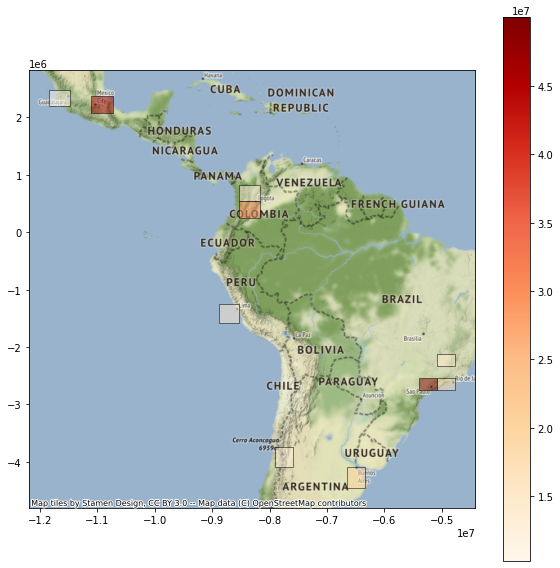

In [74]:
df_wm = ratio[ratio.ratio > 2]
df_wm.crs = "EPSG:4326"
df_wm = df_wm.to_crs(epsg=3857)
ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', 
                column='jams',legend=True, cmap='OrRd')
ctx.add_basemap(ax)

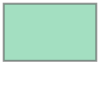

In [132]:
squares = ratio[ratio.ratio > 2]
len(squares)
polygon = squares.geo_id.tolist()[0]
polygon
geometry = wkt.loads(polygon)
geometry

## Re do of squares

In [12]:
#os.listdir(mypath)

In [13]:
def find_poly(x):
    if (x.endswith('.csv')) & ('POLYGON' in x):
        return(os.path.join(mypath, x))

cmr = '2021091413091631639640'
mypath = f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_id/{cmr}"
geo_id_path = [find_poly(x) for x in os.listdir(mypath)]
logger.debug(f'TP: {len(geo_id_path)}')


2021-09-15 13:40:50.585 | DEBUG    | __main__:<module>:8 - TP: 10


In [14]:
geo_id_path

['/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_id/2021091413091631639640/geo_grid_area_2021091413091631639640POLYGON ((-103.03175 21.71437007834323, -103.03175 19.28787871700466, -106.33453125 19.28787871700466, -106.33453125 21.71437007834323, -103.03175 21.71437007834323)).csv',
 '/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_id/2021091413091631639640/geo_grid_area_2021091413091631639640POLYGON ((-42.86048846065484 -22.25973467138916, -42.86048846065484 -23.99413506362532, -45.6729060889336 -23.99413506362532, -45.6729060889336 -22.25973467138916, -42.86048846065484 -22.25973467138916)).csv',
 '/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_id/2021091413091631639640/geo_grid_area_2021091413091631639640POLYGON ((-45.6729060889336 -18.79093388691683, -42.86048846065484 -18.79093388691683, -42.86048846065484 -20.52533427915299, -45.6729060889336 -20.52533427915299, -45.6729060889336 -18.79093388691683)).csv',
 '/home/soniame

In [5]:
df_squares = pd.DataFrame()
for path in geo_id_path:
    if path != None: 
        df = pd.read_csv(path)
        df['polygon'] = path[path.find('POL'):].replace('.csv', '')
        df_squares = df_squares.append(df)
        
logger.debug(f'New squares: {len(df_squares)}')        

2021-09-15 13:15:02.289 | DEBUG    | __main__:<module>:8 - TP: 10
2021-09-15 13:15:02.991 | DEBUG    | __main__:<module>:17 - New squares: 297


In [18]:
path =  '/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_id/2021091413091631639640/geo_grid_area_202109141309163163964'#geo_id_path[0]
path.find('POL')

-1

In [193]:
(df_squares
 >> group_by('polygon')
 >> summarize(count = _.geometry.count())
)

,polygon,count
0,"POLYGON ((-103.03175 21.71437007834323, -103.0...",29
1,POLYGON ((-42.86048846065484 -22.2597346713891...,32
2,POLYGON ((-45.6729060889336 -18.79093388691683...,30
3,POLYGON ((-48.48532371721236 -23.9941350636253...,32
4,POLYGON ((-59.73499423032741 -37.1322753113907...,31
5,POLYGON ((-68.1722471151637 -31.89189204725532...,15
6,"POLYGON ((-73.30671875 2.170599169624747, -76....",32
7,"POLYGON ((-76.6095 -11.21859601205401, -76.609...",32
8,"POLYGON ((-76.6095 4.790790801692445, -76.6095...",32
9,POLYGON ((-99.72896875000001 20.74968832471787...,32


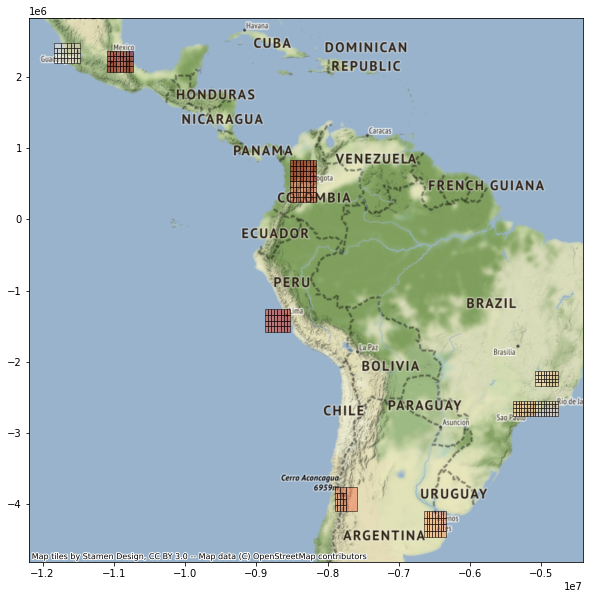

In [183]:
tab = df_squares
tab['geometry'] = gpd.GeoSeries.from_wkt(tab['geometry'])
tab = gpd.GeoDataFrame(tab, geometry='geometry')

tab.crs = "EPSG:4326"
tab = tab.to_crs(epsg=3857)
ax = tab.plot(figsize=(10, 10), alpha=0.5, edgecolor='k',legend=True, cmap='OrRd')
ctx.add_basemap(ax)